In [1]:
import numpy as np
from scipy.io import matlab
import matplotlib.pyplot as plt

__header__ __version__ __globals__ M1
(451, 161, 400) float64 -0.9007323949209264 1.0


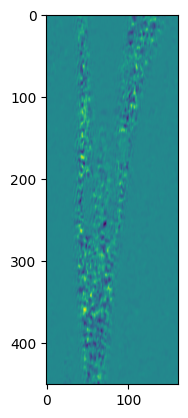

In [2]:
data = matlab.loadmat('data/BD-RPCA/simu_conv.mat')
print(*data.keys())
M1 = data['M1']
print(M1.shape, M1.dtype, np.min(M1), np.max(M1))
r,c,l = M1.shape
M = M1.reshape((-1, l))

plt.imshow(np.sum(M1, axis=2) / l)

In [3]:
from dataclasses import dataclass, field
from tqdm import tqdm

np1d = np.ndarray[tuple[int], np.dtype[np.float_]]
np2d = np.ndarray[tuple[int,int], np.dtype[np.float_]]

def shrink(arr: np2d, tau: float) -> np2d:
    return np.sign(arr) * np.maximum((np.abs(arr) - tau), 0)  #type:ignore

def svd_threshold(arr: np2d, tau: float) -> np2d:
    u, s, v = np.linalg.svd(arr, full_matrices=False)
    return u @ np.diag(shrink(s, tau)) @ v

@dataclass
class RPCA:
    """Robust PCA analysis based on"""
    L: np2d
    S: np2d

    @classmethod
    def fit(cls, m: np2d, mu:float|None=None, tol:float|None=None, max_iter=1000, iter_print=100) -> "RPCA":  #type:ignore
        """Fits L and S from X = L + S given X. Algorithm from https://arxiv.org/pdf/0912.3599.pdf, Algorithm 1, page 29"""
        if mu is None:
            mu: float = np.prod(m.shape) / (4*np.linalg.norm(m, ord=1))  # type:ignore
        mu_recip = 1/mu

        lamda: float = 1/np.sqrt(np.max(m.shape))

        err = np.inf
        s = np.zeros_like(m)
        y = np.zeros_like(m)
        l = np.zeros_like(m)

        if not tol:
            tol:float = 1e-7 * np.linalg.norm(m, ord='fro')  # type:ignore

        print(f'{mu=}, {lamda=}, {tol=}')

        try:
            for i in tqdm(range(max_iter)):
                l = svd_threshold(m - s+mu_recip * y, mu_recip)
                s = shrink(m - l + (mu_recip * y), mu_recip * lamda)
                y += mu * (m - l - s)
                err = np.linalg.norm(m - l - s, ord='fro')

                if (i % iter_print) == 0 or i == max_iter:
                    tqdm.write(f'{err=}')
                
                if err <= tol:
                    tqdm.write(f'{err=} (under tolerance, stopping)')
                    break
        except KeyboardInterrupt:
            pass

        return cls(l, s)

    def __call__(self, x: np1d|np2d) -> np1d|np2d:
        return self.L @ x

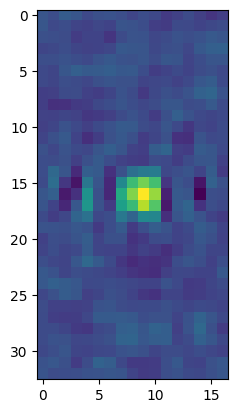

In [5]:
data = matlab.loadmat("data/BD-RPCA/psf_simu.mat")
psf = data['psf']
plt.imshow(psf)

In [6]:
m_hh, n_hh = psf.shape
1-np.array([np.floor((m_hh+1)/2), np.floor((n_hh+1)/2)])

array([-16.,  -8.])

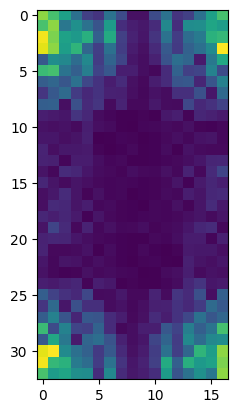

In [7]:
from bdrpca import DRPCA

m_hh, n_hh = psf.shape
shift_h = np.zeros((r*c, l))
shift_h[:m_hh, :n_hh] = psf
H = np.fft.fft2(np.roll(psf, 1-np.array([np.floor((m_hh+1)/2), np.floor((n_hh+1)/2)], dtype=int)))
plt.imshow(np.abs(H))

In [8]:
from scipy.signal import hilbert2

def dopplerplot(X, test=False):
    _,_,l = X.shape

    amp = 35
    pw = 1/l * np.sum(np.abs(X)**2, axis=2)
    pwtd = pw/np.max(pw)
    pwtd1 = np.maximum(pwtd, 10**(-amp/10))
    log_pwtd = 10 * np.log10(pwtd1)

    plt.xlabel('N_X [nb]')
    plt.ylabel('N_Z [nb]')
    cb = plt.imshow(log_pwtd)
    plt.colorbar(cb)

def rf2bmode(RF, increase=0):
    res = np.copy(RF)
    for i in range(RF.shape[2]):
        tmp = 20 * np.log10(np.abs(hilbert2(RF[:,:,i]))+increase)
        tmp -= np.min(tmp)
        bmax = np.max(tmp)
        res[:,:,i] = 255 * tmp/bmax

In [9]:
# Fig 1

In [11]:
# Fig 2a

seuil_tissu = 2
seuil_bruit = 15

Mnew = M.T @ M
V, D2, Vt = np.linalg.svd(Mnew)
D = np.sqrt(D2)
U = M @ V / D

f = np.ones((l,))
f[:seuil_tissu] = 0
f[seuil_bruit:] = 0
If = np.diag(f)
Mf = M @ V @ If @ V.T
Mfinal = Mf.reshape((r, c, l))

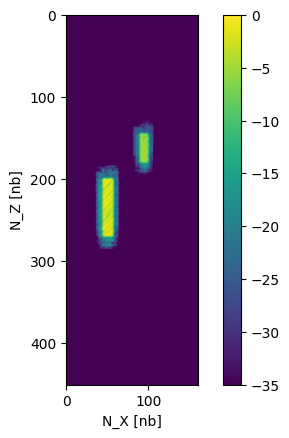

In [12]:
dopplerplot(Mfinal)

In [15]:
lamda = 3 / np.sqrt(np.maximum(r*c, l))
fit = RPCA.fit(M, lamda, iter_print=1)
Mfinale = fit.S.reshape((r,c,l))
dopplerplot(Mfinale)

mu=0.011133200893013477, lamda=0.0037110669643378256, tol=5.567905584287633e-05


  0%|          | 1/1000 [00:25<7:12:04, 25.95s/it]

err=170.40432853628946


 10%|█         | 101/1000 [31:11<5:16:38, 21.13s/it]

err=0.8987053377046833


 12%|█▏        | 116/1000 [36:46<4:40:13, 19.02s/it]


KeyboardInterrupt: 